In [1]:
import mne
file = "/Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names


import numpy as np
np.savetxt('raw.txt',raw_data[0])  #Save it as a txt file
sampling_freq = 1/1000  #This is the sampling frequency
N = raw_data[0].size  #The number of point

ECG_array = raw_data[0] #Copy the data into an ndarray, which does the same thing with the former step
ECG_array.size

xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)

ECG_array = ECG_array[150000:-300000]  # Remove the signal in first 3minutes and last 5minutes

index = np.linspace(0, round((N-1)*sampling_freq,4), N)

Extracting EDF parameters from /Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [2]:
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

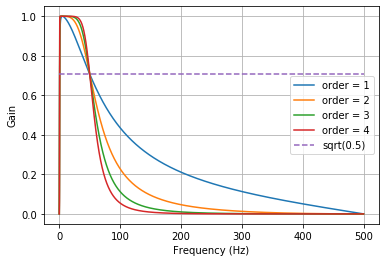

In [3]:
from scipy.signal import freqz
from scipy import signal
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

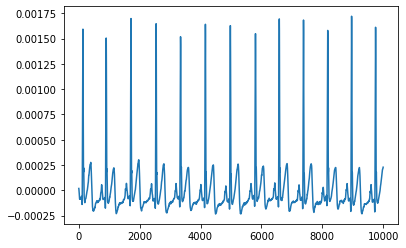

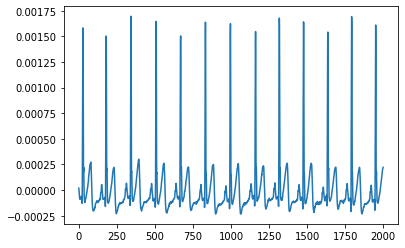

In [4]:
y = butter_bandpass_filter(ECG_array, lowcut, highcut, fs, order=2)
recover_ECG_example = y[370000:380000]
plt.plot(recover_ECG_example)
plt.show()

resampled_signal = signal.resample(y, 564000)
plt.plot(resampled_signal[74000:76000])
plt.show()

np.savetxt('resampled_signal_ecg.txt',resampled_signal)


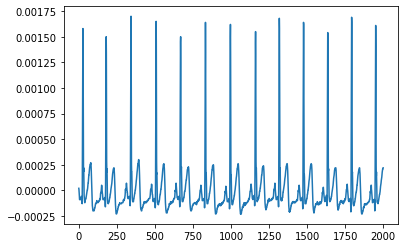

In [5]:
rounded_signal = np.around(resampled_signal, 5)
plt.plot(rounded_signal[74000:76000])
plt.show()

In [6]:
rounded_signal.size

564000

In [7]:
from scipy.fftpack import fft, dct
aN = dct(rounded_signal, type = 2, norm = 'ortho')
aN.size

564000

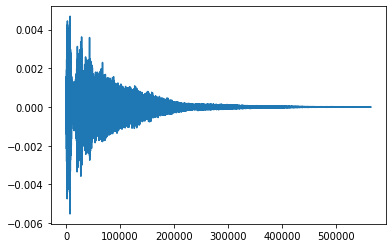

In [8]:
plt.plot(aN)

In [9]:
def return_N(target):
    if target > 1:
        for i in range(1, int(target)):
            if (2 ** i >= target):
                return i-1
    else:
        return 1


In [10]:
from itertools import islice 
split_list = [1]
for i in range(0,return_N(aN.size)):
    split_list.append(2 ** i)
temp = iter(aN) 
res = [list(islice(temp, 0, ele)) for ele in split_list] 

In [11]:
from scipy.fftpack import fft, dct, idct
len(res)

20

In [12]:
for k in range(2,len(res)):
    print(int(len(res[k])/2))

1
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072


In [13]:
from scipy.fftpack import fft, dct, idct
cN_idct = [list(idct(res[0], type = 2, norm = 'ortho' )), list(idct(res[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res)):
    cN_idct.append(list(idct(res[k], type = 2, norm = 'ortho' )))

In [14]:
all_numbers = []
for i in cN_idct:
    for j in i:
        all_numbers.append(j)
len(all_numbers)

524288

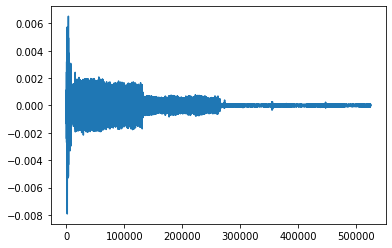

In [15]:
plt.plot(all_numbers)
plt.show()

In [16]:
all_numbers = np.asarray(all_numbers)

In [17]:
#EPE = E_Th/E *100%
# Dead-zone quantization

In [18]:
new_cN_idct = all_numbers*10**4

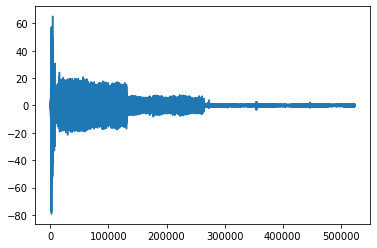

In [19]:
plt.plot(new_cN_idct)
plt.show()

In [20]:
new_cN_idct

array([-0.06005332,  0.09334462, -0.01921419, ...,  0.04041193,
        0.06943334, -0.00519902])

In [21]:
int_cN = np.round(new_cN_idct)

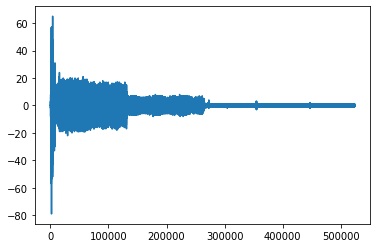

In [22]:
plt.plot(int_cN)
plt.show()

In [23]:
def RLE(input_data):
    RLE_VALUE = []
    RLE_FREQ = []
    count = 0
    for i in range(0,len(input_data)):
        if i == len(input_data)-1:
            if input_data[i] != input_data[i-1]:
                RLE_VALUE.append(input_data[i])
                RLE_FREQ.append(1)
                return RLE_VALUE, RLE_FREQ
            else:
                return RLE_VALUE, RLE_FREQ
        else:
            if input_data[i] == input_data[i+1]:
                RLE_VALUE.append(input_data[i])
                count += 1
            else:
                RLE_VALUE.append(input_data[i])
                count += 1
                RLE_FREQ.append(count)
                count = 0


In [24]:
test_list = [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0]
value, freq = RLE(test_list)
print(value)
print(freq)

[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0]
[3, 1, 1, 2, 1]


In [25]:
value, freq = RLE(int_cN)


In [26]:
np.savetxt('raw.txt',raw_data[0], fmt='%.3f')
np.savetxt('resampled_signal_ecg.txt',resampled_signal,fmt='%.3f')
np.savetxt('ecg_value_rle.txt',value, fmt='%.3f')
np.savetxt('ecg_freq_rle.txt',freq, fmt='%.3f')

In [27]:
np.savetxt('int_cN.txt',int_cN, fmt='%.3f')

### Evaluation 

#### DCT and with RLE coding

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | 3.11 | 8.974% |
| PPG |  | % |
| ACC |  | % |
| EDA |  | % |
| TEMP |  | % |

#### DCT and with Huffman coding

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | 33.32 | 8.974% |
| PPG |  | % |
| ACC |  | % |
| EDA |  | % |
| TEMP |  | % |

In [28]:
int_cN

array([-0.,  0., -0., ...,  0.,  0., -0.])

In [29]:
recover_signal = int_cN / 10**4
recover_signal = list(recover_signal)
len(recover_signal)

524288

In [30]:
split_list = [1]
for i in range(0,return_N(len(recover_signal))+1):
    split_list.append(2 ** i)
temp_recovered = iter(recover_signal) 
res_recovered = [list(islice(temp_recovered, 0, ele)) for ele in split_list] 

In [31]:
len(res)

20

In [32]:
recover_dct = [list(dct(res_recovered[0], type = 2, norm = 'ortho' )), list(dct(res_recovered[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered)):
    recover_dct.append(list(dct(res_recovered[k], type = 2, norm = 'ortho' )))

In [33]:
all_recover = []
for i in recover_dct:
    for j in i:
        all_recover.append(j)
len(all_recover)

524288

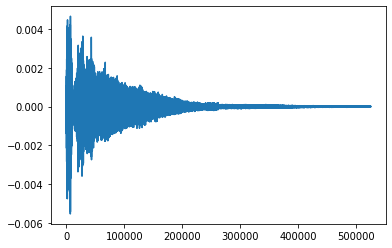

In [34]:
plt.plot(all_recover)

In [35]:
aN_recover = idct(all_recover, type = 2, norm = 'ortho')

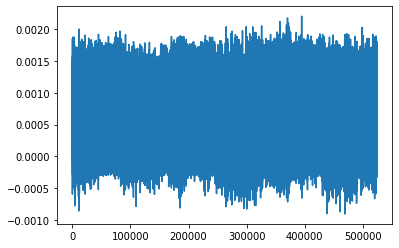

In [36]:
plt.plot(aN_recover)
plt.show()

In [37]:
final_recovered = aN_recover[:524288]
len(final_recovered)

524288

NameError: name 'resampled_signal_shorter' is not defined

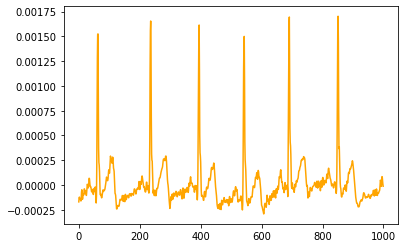

In [38]:
#plt.plot(resampled_signal_shorter[74000:75000], label = "origianl")

plt.plot(final_recovered[74000:75000], label = "recovered", color = 'orange')
plt.plot(resampled_signal_shorter[74000:75000], label = "origianl")
plt.legend()
plt.title('ECG')
plt.grid()
plt.show()

In [ ]:
resampled_signal_shorter = signal.resample(y, len(final_recovered))
#resampled_signal_shorter = rounded_signal[:len(final_recovered)] 
from sklearn.metrics import mean_squared_error
from math import sqrt

def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal_shorter, final_recovered)
print("The PRD is {}%".format(round(PRD*100,3)))

In [ ]:
final_recovered.shape

In [ ]:
signal.resample(y, 564000)